In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.metrics import roc_curve
from sklearn.feature_extraction import DictVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from IPython.display import display

In [2]:
df = pd.read_csv('../scikit-learning data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.TotalCharges = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
for col in df.dtypes[df.dtypes == object].index:
    df[col] = df[col].str.lower().str.replace(' ', '_')
df.churn = (df.churn == 'yes').astype(int)
df.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,0
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,...,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,0
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,...,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,1
3,7795-cfocw,male,0,no,no,45,no,no_phone_service,dsl,yes,...,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,0
4,9237-hqitu,female,0,no,no,2,yes,no,fiber_optic,no,...,no,no,no,no,month-to-month,yes,electronic_check,70.70,151.65,1


In [4]:
df_train_full, df_test = train_test_split(df, test_size=0.2,random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33,random_state=11)

y_train = df_train['churn']
y_val = df_val['churn']
y_test = df_test['churn']

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
categorical = [ 'gender', 'seniorcitizen', 'partner', 'dependents',
        'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod' ]
numerical =['tenure','monthlycharges', 'totalcharges']

In [6]:
df[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

In [7]:
global_mean = df_train_full['churn'].mean()

In [8]:
#计算互信息
df_mi = df_train_full[categorical].apply(lambda x : mutual_info_score(x,df_train_full.churn))
df_mi = df_mi.sort_values(ascending=False).to_frame(name= 'MI')
df_mi

,MI
contract,0.098320
onlinesecurity,0.063085
techsupport,0.061032
internetservice,0.055868
onlinebackup,0.046923
deviceprotection,0.043453
paymentmethod,0.043210
streamingtv,0.031853
streamingmovies,0.031581
paperlessbilling,0.017589


In [9]:
df_train_full[numerical].corrwith(df_train_full.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

In [10]:
dv = DictVectorizer(sparse=False)

train_dict = df_train [categorical+numerical].to_dict(orient = 'records')
dv.fit(train_dict)
X_train = dv.transform(train_dict)
X_train[0]

array([0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
       1.0000e+00, 0.0000e+00, 0.0000e+00, 8.6100e+01, 1.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 7.1000e+01, 6.0459e+03])

In [11]:
model = LogisticRegression(solver='liblinear',random_state=1)
model.fit(X_train,y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [12]:
val_dict = df_val[categorical + numerical].to_dict('records')
X_val = dv.transform(val_dict)

In [13]:
y_pred = model.predict_proba(X_val)
y_pred = y_pred[:,1]

In [14]:
dict(zip(dv.get_feature_names_out(),model.coef_[0].round(3)))

{'contract=month-to-month': np.float64(0.563),
 'contract=one_year': np.float64(-0.086),
 'contract=two_year': np.float64(-0.599),
 'dependents=no': np.float64(-0.03),
 'dependents=yes': np.float64(-0.092),
 'deviceprotection=no': np.float64(0.1),
 'deviceprotection=no_internet_service': np.float64(-0.116),
 'deviceprotection=yes': np.float64(-0.106),
 'gender=female': np.float64(-0.027),
 'gender=male': np.float64(-0.095),
 'internetservice=dsl': np.float64(-0.323),
 'internetservice=fiber_optic': np.float64(0.317),
 'internetservice=no': np.float64(-0.116),
 'monthlycharges': np.float64(0.001),
 'multiplelines=no': np.float64(-0.168),
 'multiplelines=no_phone_service': np.float64(0.127),
 'multiplelines=yes': np.float64(-0.081),
 'onlinebackup=no': np.float64(0.136),
 'onlinebackup=no_internet_service': np.float64(-0.116),
 'onlinebackup=yes': np.float64(-0.142),
 'onlinesecurity=no': np.float64(0.258),
 'onlinesecurity=no_internet_service': np.float64(-0.116),
 'onlinesecurity=yes':

In [15]:
customer = {
    'customer_id' : '8879-zkjof',
    'gender' : 'female',
    'seniorcitizen' : 0,
    'partner' : 'no',
    'dependents' : 'no',
    'tenure' : 41,
    'phoneservice' : 'yes',
    'multiplelines' : 'no',
    'internetservice' : 'dsl',
    'onlinesecurity' : 'yes',
    'onlinebackup' : 'no',
    'deviceprotection' : 'yes',
    'techsupport' : 'yes',
    'streamingtv' : 'yes',
    'streamingmovies' : 'yes',
    'contract' : 'one_year',
    'paperlessbilling' : 'yes',
    'paymentmethod' : 'bank_transfer_(automatic)',
    'monthlycharges' : 79.85,
    'totalcharges' : 3320.75
}
X_test = dv.transform(customer)

In [16]:
model.predict_proba(X_test)[0,1]

np.float64(0.07332239057816664)

In [17]:
def tpr_fpr(y_val,y_pred):
    scores = []
    thresholds = np.linspace(0,1,101)
    
    for t in thresholds:
        tp = ((y_val == 1)&(y_pred >= t)).sum()
        fp = ((y_val == 0)&(y_pred >= t)).sum()   
        tn = ((y_val == 0)&(y_pred < t)).sum()
        fn = ((y_val == 1)&(y_pred < t)).sum()
        scores.append((t,tp,fp,tn,fn))
        
    df_scores = pd.DataFrame(scores,columns=['threshold','TP','FP','TN','FN'])
    df_scores['TPR'] = df_scores['TP'] / (df_scores['TP'] + df_scores['FN'])
    df_scores['FPR'] = df_scores['FP'] / (df_scores['FP'] + df_scores['TN'])
    return df_scores   

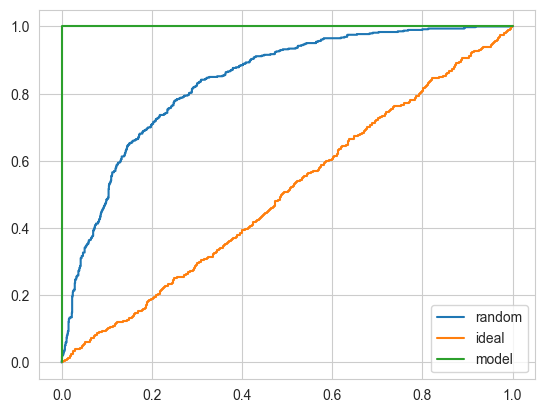

In [23]:
y_rand = np.random.uniform(0,1,size =len(y_val))
df_rand = tpr_fpr(y_val,y_rand)       #随机预测

n_churn = y_val.sum()            #理想模型
n_no_churn = len(y_val[y_val == 0])
y_ideal = np.repeat([0,1],[n_no_churn,n_churn])
y_pred_ideal = np.linspace(0,1,n_churn+n_no_churn)

'''df_ideal = tpr_fpr(y_ideal,y_pred_ideal)
df_model = tpr_fpr(y_val,y_pred)'''

fpr_val,tpr_val,threshold = roc_curve(y_val,y_pred)
fpr_rand,tpr_rand,threshold = roc_curve(y_val,y_rand)
fpr_ideal,tpr_ideal,threshold = roc_curve(y_ideal,y_pred_ideal)


plt.plot(fpr_val,tpr_val,label = 'random')
plt.plot(fpr_rand,tpr_rand,label = 'ideal')
plt.plot(fpr_ideal,tpr_ideal,label = 'model')
plt.legend()

[0.00000000e+00 0.00000000e+00 0.00000000e+00 7.27802038e-04
 7.27802038e-04 1.45560408e-03 1.45560408e-03 2.18340611e-03
 2.18340611e-03 3.63901019e-03 3.63901019e-03 4.36681223e-03
 4.36681223e-03 5.82241630e-03 5.82241630e-03 6.55021834e-03
 6.55021834e-03 7.27802038e-03 7.27802038e-03 8.00582242e-03
 8.00582242e-03 8.73362445e-03 8.73362445e-03 1.09170306e-02
 1.09170306e-02 1.16448326e-02 1.16448326e-02 1.31004367e-02
 1.31004367e-02 1.38282387e-02 1.38282387e-02 1.52838428e-02
 1.52838428e-02 1.60116448e-02 1.60116448e-02 1.74672489e-02
 1.74672489e-02 2.18340611e-02 2.18340611e-02 2.25618632e-02
 2.25618632e-02 2.32896652e-02 2.32896652e-02 2.40174672e-02
 2.40174672e-02 2.47452693e-02 2.47452693e-02 2.54730713e-02
 2.54730713e-02 2.83842795e-02 2.83842795e-02 2.91120815e-02
 2.91120815e-02 2.98398836e-02 2.98398836e-02 3.05676856e-02
 3.05676856e-02 3.12954876e-02 3.12954876e-02 3.27510917e-02
 3.27510917e-02 3.34788937e-02 3.34788937e-02 3.49344978e-02
 3.49344978e-02 3.711790